In [1]:
%run runaway_functionsv3

In [7]:
cl = Cluster("Berkeley_97")
cld = ClusterDias("Berkeley_97")

cl.distance, cld.distance

(<Quantity 2769. pc>, <Distance 2485. pc>)


getting isochrone form cmd3.7 with:
Av:3.10
logage:7.00
metallicity:-0.10
isochrone downloaded in 7.2s


(<Figure size 1200x1000 with 2 Axes>,
 <AxesSubplot: title={'center': 'CMD for Berkeley_97'}, xlabel='$G_{BP}-G_{RP}$ (mag)', ylabel='$G$ (mag)'>)

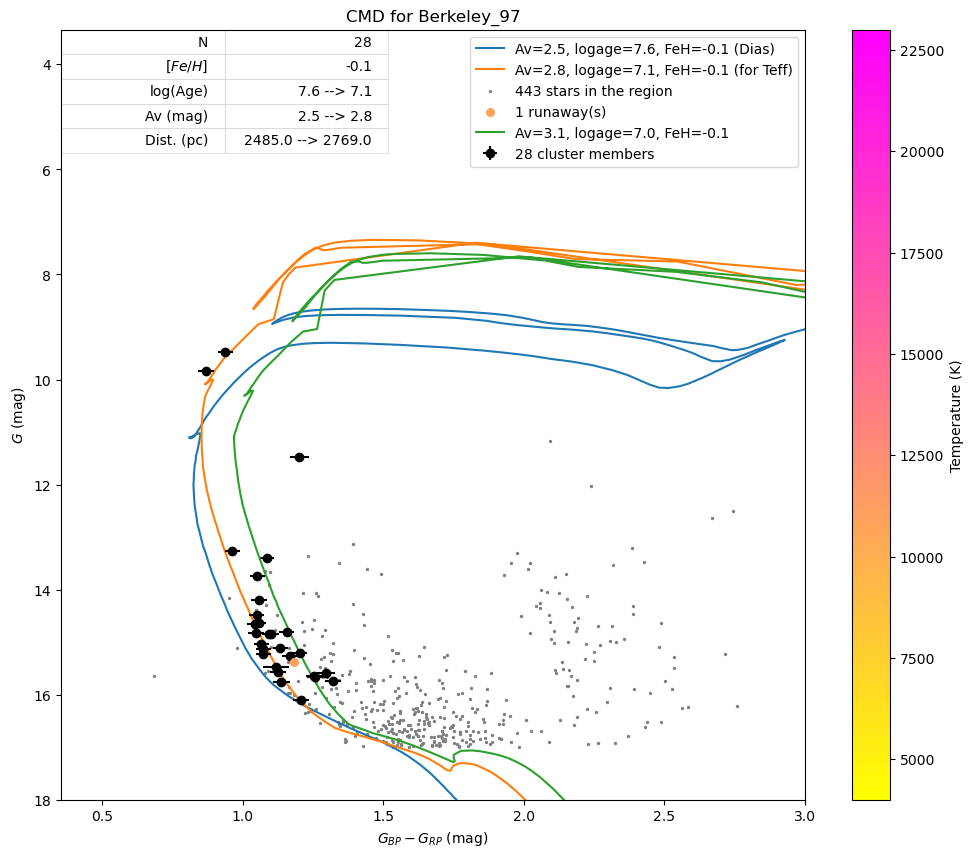

In [12]:
# Import necessary libraries
%run runaway_functionsv3

import matplotlib.pyplot as plt
from runaway_functionsv3 import Cluster, ClusterDias, estimate_temperature

# Function to plot isochrones
def plot_isochrones(ax, cluster, **kwargs):
    cluster_dias = ClusterDias(cluster.name)
    theoretical_isochrone_dias, (Av0, logage0, FeH0) = cluster_dias.theoretical_isochrone(returnparams=True)
    isochrone_theo_dias = ax.plot(
        theoretical_isochrone_dias['BP-RP'], 
        theoretical_isochrone_dias['Gmag'], 
        label=f'Av={Av0}, logage={logage0}, FeH={FeH0} (Dias, for Teff)'
    )[0]
    
    theoretical_isochrone_temp, (Av, logage, FeH) = cluster.theoretical_isochrone(kwargs, returnparams=True)
    if not (Av0 == Av and logage0 == logage and FeH0 == FeH):
        isochrone_theo_dias.set_label(f'Av={Av0}, logage={logage0}, FeH={FeH0} (Dias)')
        isochrone_theo = ax.plot(
            theoretical_isochrone_temp['BP-RP'], 
            theoretical_isochrone_temp['Gmag'], 
            label=f'Av={Av}, logage={logage}, FeH={FeH} (for Teff)'
        )[0]
    return isochrone_theo_dias

# Function to plot cluster members
def plot_cluster_members(ax, cluster):
    mymembers = cluster.mymembers
    scatter_members = ax.errorbar(
        mymembers['BP-RP'], mymembers['Gmag'], 
        color='black', zorder=2, fmt='o',
        xerr=mymembers['e_BP-RP']+0.02, yerr=mymembers['e_Gmag'],
        label=rf'{len(mymembers)} cluster members'
    )
    return scatter_members

# Function to plot stars in the region
def plot_stars_in_region(ax, cluster):
    stars_in_region = cluster.stars_in_region()
    scatter_sir = ax.scatter(
        stars_in_region['BP-RP'], stars_in_region['Gmag'],
        s=2, color='grey', zorder=1, label=f"{len(stars_in_region)} stars in the region"
    )
    return scatter_sir

# Function to plot runaways
def plot_runaways(ax, cluster, theoretical_isochrone_temp):
    runaways = cluster.runaways()
    runaways = estimate_temperature(runaways, theoretical_isochrone_temp)
    scatter_runaways = ax.scatter(
        runaways['BP-RP'], runaways['Gmag'],
        s=30, zorder=4,
        c=runaways['Temp. Est'],
        cmap='spring_r', norm=plt.Normalize(4000, 23000),
        label=f'{len(runaways)} runaway(s)'
    )
    return scatter_runaways

# Function to add colorbar
def add_colorbar(fig, scatter_runaways, ax):
    colorbar = fig.colorbar(scatter_runaways, ax=ax)
    colorbar.set_label('Temperature (K)')
    return colorbar

# Function to add cluster parameters table
def add_cluster_parameters_table(ax, cluster):
    cluster_dias = ClusterDias(cluster.name)
    print()
    cluster_table = [
        ['N', len(cluster.mymembers)],
        [r'$[Fe/H]$', cluster.FeH],
        ['log(Age)', cluster.logage],
        ['Av (mag)', round(cluster.Av.value, 2)],
        ['Dist. (pc)', str(round(cluster.distance.value))+"$\pm$"+f'{cluster.all["e_Dist"]}']
    ]

    if cluster.FeH != cluster_dias.FeH:
        cluster_table[1][1] = f'{cluster_dias.FeH:.1f} --> {round(float(cluster.FeH),1)}'
    if cluster.logage != cluster_dias.logage:
        cluster_table[2][1] = f'{cluster_dias.logage:.1f} --> {round(float(cluster.logage),1)}'
    if cluster.Av != cluster_dias.Av:
        cluster_table[3][1] = f'{cluster_dias.Av.value:.1f} --> {round(float(cluster.Av.value),1)}'
    if cluster.distance != cluster_dias.distance:
        cluster_table[4][1] = f'{cluster_dias.distance.value:.1f} --> {round(float(cluster.distance.value),1)}'

    table_bbox = [0.0, 0.84, 0.44, 0.16]  # [left, bottom, width, height]
    table = ax.table(cellText=cluster_table, cellLoc='right', loc='upper left', bbox=table_bbox)

    for key, cell in table._cells.items():
        cell.set_linewidth(0.5)
        cell.set_edgecolor('lightgray')
    return table

# Function to add additional isochrones
def add_isochrone(ax, cluster, Av, logage, FeH, parsec_version=2):
    theoretical_isochrone, _ = cluster.theoretical_isochrone({'Av': Av, 'logage': logage, 'FeH': FeH}, returnparams=True, parsec_version=parsec_version)
    isochrone_plot = ax.plot(
        theoretical_isochrone['BP-RP'], 
        theoretical_isochrone['Gmag'], 
        label=f'Av={Av}, logage={logage}, FeH={FeH}'
    )[0]
    return isochrone_plot



# Main function to plot CMD
def plot_cmd(cluster, multiple=False, **kwargs):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_xlabel(r"$G_{BP}-G_{RP}$ (mag)")
    ax.set_ylabel(r"$G$ (mag)")
    ax.set_title(f"CMD for {cluster.name}")

    isochrone_theo_dias = plot_isochrones(ax, cluster, **kwargs)
    plot_cluster_members(ax, cluster)
    plot_stars_in_region(ax, cluster)

    theoretical_isochrone_temp = cluster.theoretical_isochrone(kwargs)
    scatter_runaways = plot_runaways(ax, cluster, theoretical_isochrone_temp)
    add_colorbar(fig, scatter_runaways, ax)
    add_cluster_parameters_table(ax, cluster)

    # add_isochrone(ax, cluster, Av=3.1, logage=7.1, FeH=-0.1, parsec_version=1.2)
    add_isochrone(ax, cluster, Av=3.1, logage=7.0, FeH=-0.1, parsec_version=2)
    
    ax.set_ylim(bottom=min(theoretical_isochrone_temp['Gmag'])-4, top=18)
    ax.set_xlim(left=min(theoretical_isochrone_temp['BP-RP'])-0.5, right=3)
    ax.invert_yaxis()
    ax.legend()
    
    # Optional: make points clickable (code to be implemented)
    # make_points_clickable(ax, scatter_runaways)

    return fig, ax

# Example usage
cl = Cluster("Berkeley_97")
plot_cmd(cl)


getting isochrone from cmd3.7 (PARSEC2) with:
Av:2.54
logage:7.59
metallicity:-0.10
isochrone downloaded in 7.5s


KeyError: 'FeH'

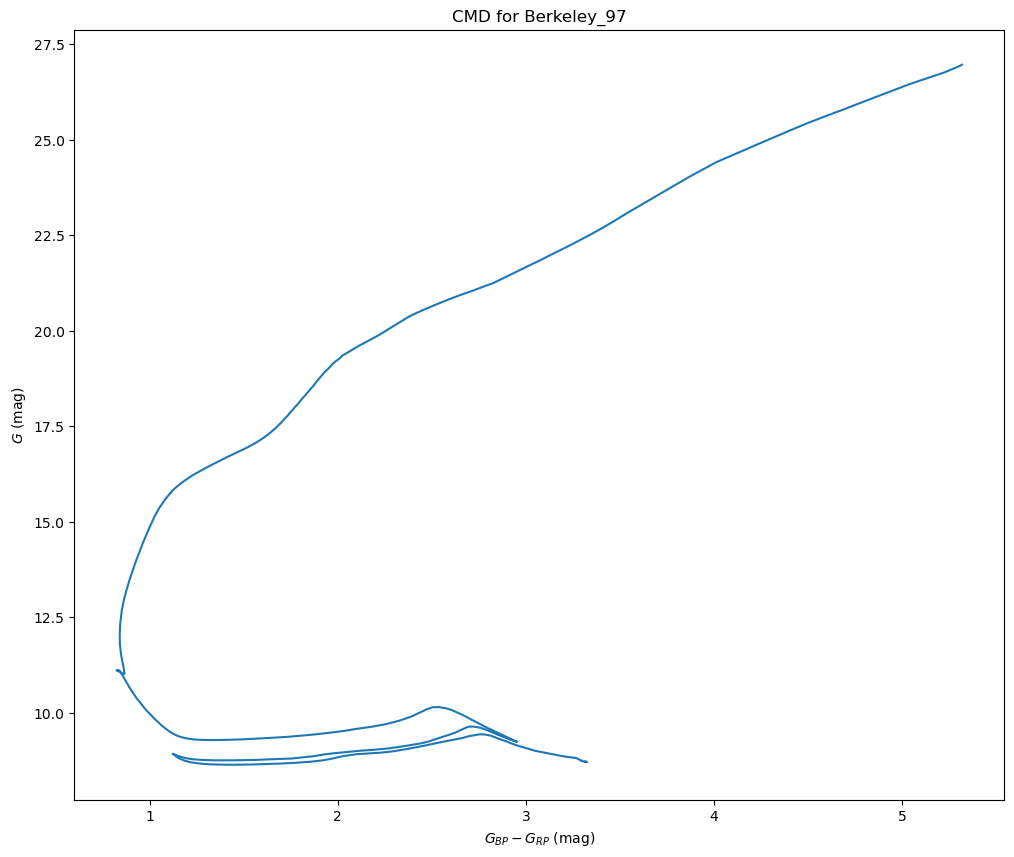

In [2]:
# Import necessary libraries
%run runaway_functionsv3

import matplotlib.pyplot as plt
from runaway_functionsv3 import Cluster, ClusterDias, estimate_temperature

class Isochrone:
    def __init__(self, cluster, Av, logage, FeH, parsec_version=2):
        self.cluster = cluster
        self.Av = Av
        self.logage = logage
        self.FeH = FeH
        self.parsec_version = parsec_version
        self.data = self._calculate_isochrone()
    
    def _calculate_isochrone(self):
        Av_value = self.Av.value if hasattr(self.Av, 'value') else self.Av
        logage_value = self.logage.value if hasattr(self.logage, 'value') else self.logage
        FeH_value = self.FeH.value if hasattr(self.FeH, 'value') else self.FeH
        
        theoretical_isochrone, _ = self.cluster.theoretical_isochrone(
            {'Av': Av_value, 'logage': logage_value, 'FeH': FeH_value}, 
            returnparams=True, 
            parsec_version=self.parsec_version
        )
        return theoretical_isochrone
    
    def plot(self, ax, label=None):
        if label is None:
            label = f'Av={self.Av}, logage={self.logage}, FeH={self.FeH}'
        ax.plot(
            self.data['BP-RP'], 
            self.data['Gmag'], 
            label=label
        )

class CMD:
    def __init__(self, cluster):
        self.cluster = cluster
        self.fig, self.ax = plt.subplots(figsize=(12, 10))
        self.ax.set_xlabel(r"$G_{BP}-G_{RP}$ (mag)")
        self.ax.set_ylabel(r"$G$ (mag)")
        self.ax.set_title(f"CMD for {self.cluster.name}")

    def plot_isochrones(self, **kwargs):
        cluster_dias = ClusterDias(self.cluster.name)
        isochrone_dias = Isochrone(cluster_dias, cluster_dias.Av, cluster_dias.logage, cluster_dias.FeH)
        isochrone_dias.plot(self.ax, label=f'Av={cluster_dias.Av}, logage={cluster_dias.logage}, FeH={cluster_dias.FeH} (Dias)')
        
        Av = kwargs.get('Av', self.cluster.Av)
        logage = kwargs.get('logage', self.cluster.logage)
        FeH = kwargs.get('FeH', self.cluster.FeH)
        
        isochrone_cluster = Isochrone(self.cluster, kwargs['Av'], kwargs['logage'], FeH)
        if (cluster_dias.Av, cluster_dias.logage, cluster_dias.FeH) != (kwargs['Av'], kwargs['logage'], FeH):
            isochrone_cluster.plot(self.ax, label=f'Av={kwargs["Av"]}, logage={kwargs["logage"]}, FeH={FeH}')
     
    def add_isochrone(self, Av, logage, FeH, parsec_version=2):
        isochrone = Isochrone(self.cluster, Av, logage, FeH, parsec_version)
        isochrone.plot(self.ax)

    def plot_cluster_members(self):
        mymembers = self.cluster.mymembers
        self.ax.errorbar(
            mymembers['BP-RP'], mymembers['Gmag'], 
            color='black', zorder=2, fmt='o',
            xerr=mymembers['e_BP-RP']+0.02, yerr=mymembers['e_Gmag'],
            label=rf'{len(mymembers)} cluster members'
        )

    def plot_stars_in_region(self):
        stars_in_region = self.cluster.stars_in_region()
        self.ax.scatter(
            stars_in_region['BP-RP'], stars_in_region['Gmag'],
            s=2, color='grey', zorder=1, label=f"{len(stars_in_region)} stars in the region"
        )

    def plot_runaways(self, theoretical_isochrone_temp):
        runaways = self.cluster.runaways()
        runaways = estimate_temperature(runaways, theoretical_isochrone_temp)
        scatter_runaways = self.ax.scatter(
            runaways['BP-RP'], runaways['Gmag'],
            s=30, zorder=4,
            c=runaways['Temp. Est'],
            cmap='spring_r', norm=plt.Normalize(4000, 23000),
            label=f'{len(runaways)} runaway(s)'
        )
        return scatter_runaways

    def add_colorbar(self, scatter_runaways):
        colorbar = self.fig.colorbar(scatter_runaways, ax=self.ax)
        colorbar.set_label('Temperature (K)')

    def add_cluster_parameters_table(self):
        cluster_dias = ClusterDias(self.cluster.name)
        cluster_table = [
            ['N', len(self.cluster.mymembers)],
            [r'$[Fe/H]$', self.cluster.FeH],
            ['log(Age)', self.cluster.logage],
            ['Av (mag)', round(self.cluster.Av.value, 2)],
            ['Dist. (pc)', str(round(self.cluster.distance.value))+"$\pm$"+f'{self.cluster.all["e_Dist"]}']
        ]

        if self.cluster.FeH != cluster_dias.FeH:
            cluster_table[1][1] = f'{cluster_dias.FeH:.1f} --> {round(float(self.cluster.FeH),1)}'
        if self.cluster.logage != cluster_dias.logage:
            cluster_table[2][1] = f'{cluster_dias.logage:.1f} --> {round(float(self.cluster.logage),1)}'
        if self.cluster.Av != cluster_dias.Av:
            cluster_table[3][1] = f'{cluster_dias.Av.value:.1f} --> {round(float(self.cluster.Av.value),1)}'
        if self.cluster.distance != cluster_dias.distance:
            cluster_table[4][1] = f'{cluster_dias.distance.value:.1f} --> {round(float(self.cluster.distance.value),1)}'

        table_bbox = [0.0, 0.84, 0.44, 0.16]  # [left, bottom, width, height]
        table = self.ax.table(cellText=cluster_table, cellLoc='right', loc='upper left', bbox=table_bbox)

        for key, cell in table._cells.items():
            cell.set_linewidth(0.5)
            cell.set_edgecolor('lightgray')

    def plot_cmd(self, **kwargs):
        self.plot_isochrones(**kwargs)
        self.plot_cluster_members()
        self.plot_stars_in_region()

        theoretical_isochrone_temp = self.cluster.theoretical_isochrone(kwargs)
        scatter_runaways = self.plot_runaways(theoretical_isochrone_temp)
        self.add_colorbar(scatter_runaways)
        self.add_cluster_parameters_table()

        self.ax.set_ylim(bottom=min(theoretical_isochrone_temp['Gmag'])-4, top=18)
        self.ax.set_xlim(left=min(theoretical_isochrone_temp['BP-RP'])-0.5, right=3)
        self.ax.invert_yaxis()
        self.ax.legend()
        plt.show()

# Example usage
cl = Cluster("Berkeley_97")
cmd_plot = CMD(cl)
cmd_plot.plot_cmd(Av=3.1, logage=7.1)
cmd_plot.add_isochrone(Av=2.5, logage=8.0, FeH=-0.1)


In [13]:
dias2021 = Table.read("dias2021.tsv", format="ascii.ecsv")
maskplx = dias2021['Plx'] > 0.3
maskage = dias2021['logage'] < 7.7
workclusters = []
for clustername in dias2021[maskplx & maskage][:]['Cluster']:
    if clustername not in ['ASCC_79','BH_164','BH_23','Collinder_135','Collinder_140','Gulliver_9','IC_2391','IC_2602','Mamajek_1','Platais_8','UPK_535','UPK_606','UPK_640','Berkeley_59','COIN-Gaia_37','Ivanov_4','LP_1937','Sigma_Ori','UBC_632']:
        workclusters.append(clustername)
        # print(clustername)
        # cl = Cluster(clustername)
        # cl.prepare_trace()
# cl.stars_in_region()
# cl.stars_in_region()

In [ ]:
workclusters_mask = [cluster in workclusters for cluster in dias2021['Cluster']]
workclusterstable = dias2021[workclusters_mask]

rvexists = workclusterstable['RV'].mask
nrvgood = workclusterstable['NRV'] > 4

workclusterstable[~rvexists & nrvgood]

In [ ]:
def runaways_from(clustername):
    cl = Cluster(clustername)
    fs4giesler = cl.fast_stars_in_region()
    outputs = os.listdir(f"/home/surodeep/suro_aiu/traceback/cluster_runaway/{cl.name}/runaways/")
    linenos = []
    for output in outputs:
        #print(output)
        if 'run' in output:
            linenos.append(int(output.split("+")[1].replace(".out","")))
    linenos.sort()
    # print(linenos)
    i=np.array(linenos)-3
    def source_of(lineno, input_table):
        return input_table[lineno-2]['Source']
    return fs4giesler[i]
for cluster in workclusters:
    t = runaways_from(cluster)[runaways_from(cluster)['Teff'].argmax()]['Teff']
    
    if t>10000:
        print(cluster, t,runaways_from(cluster)[runaways_from(cluster)['Teff'].argmax()]['Source'])